In [1]:
# インポート
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
import statsmodels.api as sm
from decimal import Decimal, ROUND_HALF_UP
from sklearn.metrics import mean_squared_error
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from mlxtend.plotting import plot_decision_regions
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

import tensorflow as tf
from keras.datasets import mnist

In [369]:
import numpy as np


def smooth_curve(x):
    """損失関数のグラフを滑らかにするために用いる
    参考：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]


def shuffle_dataset(x, t):
    """データセットのシャッフルを行う
    Parameters
    ----------
    x : 訓練データ
    t : 教師データ
    Returns
    -------
    x, t : シャッフルを行った訓練データと教師データ
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

# 1次元の畳み込みニューラルネットワークスクラッチ

畳み込みニューラルネットワーク（CNN） のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


このSprintでは1次元の 畳み込み層 を作成し、畳み込みの基礎を理解することを目指します。次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。


クラスの名前はScratch1dCNNClassifierとしてください。クラスの構造などは前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください。


### 1次元畳み込み層とは
CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多いです。


畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。


### データセットの用意
検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

In [2]:
#(X_train, y_train), (X_test, y_test) = mnist.load_data()

#print(X_train.shape) # (60000, 28, 28)
#print(X_test.shape) # (10000, 28, 28)
#print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8


## まず適当なテストデータを作る
1dCNNは多くの場合で時系列解析に用いられます。そのため、テストデータは簡単な異常検知モデルにしてみましょう。

※本来、時系列の異常検知システムは逐次的に見ることが多いので、本当はこんな風にバッチごとに見るようなことは少ないです。

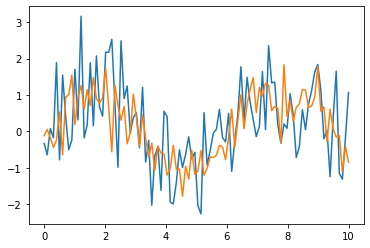

In [4]:
data_length = 100
n_sample = 100000
anomaly_noise = np.random.randn(data_length)    #異常値は分散が大きい
nomaly_noise  = np.random.randn(data_length)/2  #正常値は分散が小さい

#時系列とラベルを生成
t = np.linspace(0,10,data_length)
x_anomaly = np.array([np.sin(t) + anomaly_noise for i in range(n_sample//2)])
x_nomaly  = np.array([np.sin(t) + nomaly_noise  for i in range(n_sample//2)])
X = np.concatenate([x_anomaly,x_nomaly])
y = np.concatenate([np.ones(n_sample//2),np.zeros(n_sample//2)])

#シャッフル
rand_idx = np.arange(n_sample)
np.random.shuffle(rand_idx)
X = X[rand_idx,:]
y = y[rand_idx]

#描画
plt.plot(t,x_anomaly[0,:])
plt.plot(t,x_nomaly[0,:])
plt.show()

ここでは二値分類となっていますが、OneHotEncodingすれば、問題なく実行されるはずなので、二値ですがOneHotEncodingしましょう。

もちろん二値分類用に別に出力層を作っても問題ありません。余力があればぜひやってみてください。

In [6]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y[:, np.newaxis])
print(y.shape) # (100000,)
print(y_one_hot.shape) # (100000, 2)
print(y_one_hot.dtype) # float64

(100000,)
(100000, 2)
float64


In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_train.shape

(75000, 100)

# 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成
チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。


ここでは パディング は考えず、ストライド も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_i=\Sigma^{F-1}_{s=0} x_\left(i+s\right)w_s+b
$$

$a_i$ : 出力される配列のi番目の値


$F$ : フィルタのサイズ


$x_{(i+s)}$ : 入力の配列の(i+s)番目の値


$w_s$ : 重みの配列のs番目の値


$b$ : バイアス項


全てスカラーです。


次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。


$$
w′_s=w_s - \alpha\frac{\partial L}{\partial w_s}
$$
$$
b′=b - \alpha\frac{\partial L}{\partial b}
$$

$\alpha$ : 学習率


$\frac{\partial L}{\partial w_s}$ : $w_s$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial b}$ : $b$ に関する損失 $L$ の勾配


勾配 $\frac{\partial L}{\partial w_s}$ や $\frac{\partial L}{\partial b}$ を求めるためのバックプロパゲーションの数式が以下です。

$$
\frac{\partial L}{\partial w_s}=\Sigma^{N_{out}-1}_{i=0} \frac{\partial L}{\partial a_i}x_{(i+s)}
$$
$$
\frac{\partial L}{\partial b}=\Sigma^{N_{out}-1}_{i=0} \frac{\partial L}{\partial a_i}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi番目の値


$N_{out}$ : 出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_j}=\Sigma^{F-1}_{s=0} \frac{\partial L}{\partial a_{(j-s)}}w_s
$$

$\frac{\partial L}{\partial x_j}$ : 前の層に流す誤差の配列のj番目の値


ただし、 $j-s<0$ または $j-s>N_{out}-1$ のとき $\frac{\partial L}{\partial a_{(j-s)}} =0$ です。


全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。



In [ ]:
class CNN_1d_:
    def __init__(self, p=0, s=1):
        self.padding = p
        self.stride = s
    
    def forward(self, X, filter_size):
        self.X = X
        self.input_size = len(X)
        self.filter_size = filter_size
        self.W = np.random.randint(-2,2,3) 
        self.B = np.array([1])
        # 入力が二次元の場合は、HWそれぞれ計算する
        self.output_size = ((self.input_size + self.p*2 - self.filter_size) / self.stride) + 1
        
        
    
    def backward(self):
        pass

In [15]:
XX = np.random.randint(0, 10, 10)
ww = np.random.randint(-2,2, 3)
print(XX)
print(ww)

[9 9 2 3 6 2 6 4 4 3]
[1 1 0]


# 【問題2】1次元畳み込み後の出力サイズの計算
畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。

$$
N_{out} = \frac{N_{in}+2P-F}{S}+1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ

In [716]:
def calc_out_shape(Nin, F, P=0, S=1):
    out = ((Nin + 2*P - F) / S ) + 1
    return out


In [717]:
calc_out_shape(100, 3)

98.0

# 【問題3】小さな配列での1次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。


入力x、重みw、バイアスbを次のようにします。



```
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
```

フォワードプロパゲーションをすると出力は次のようになります。

```
a = np.array([35, 50])
```

次にバックプロパゲーションを考えます。誤差は次のようであったとします。


```
delta_a = np.array([10, 20])
```

バックプロパゲーションをすると次のような値になります。

```
delta_b = np.array([30])
delta_w = np.array([50, 80, 110])
delta_x = np.array([30, 110, 170, 140])
```

### 実装上の工夫
畳み込みを実装する場合は、まずはfor文を重ねていく形で構いません。しかし、できるだけ計算は効率化させたいため、以下の式を一度に計算する方法を考えることにします。

$$
a_i=\Sigma^{F-1}_{s=0}x_{(i+s)}w_s+b
$$

バイアス項は単純な足し算のため、重みの部分を見ます。

$$
\Sigma^{F-1}_{s=0}x_{(i+s)}w_s
$$
これは、xの一部を取り出した配列とwの配列の内積です。具体的な状況を考えると、以下のようなコードで計算できます。この例では流れを分かりやすくするために、各要素同士でアダマール積を計算してから合計を計算しています。これは結果的に内積と同様です。

```
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
a = np.empty((2, 3))
indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)
a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である
a = a.sum(axis=1)
```

ndarrayは配列を使ったインデックス指定ができることを利用した方法です。


また、二次元配列を使えば一次元配列から二次元配列が取り出せます。

```
x = np.array([1, 2, 3, 4])
indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)
print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])
```

このこととブロードキャストなどをうまく組み合わせることで、一度にまとめて計算することも可能です。


畳み込みの計算方法に正解はないので、自分なりに効率化していってください。


《参考》


以下のページのInteger array indexingの部分がこの方法についての記述です。


[Indexing — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)

In [610]:
# サンプル
x = np.array([1, 2, 3, 4])
y = np.array([45,70])
w = np.array([3, 5, 7])
a = np.empty((2, 3))
indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)
a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である
a = a.sum(axis=1)
a

array([34., 49.])

### 【解答】

In [611]:
def Forward(X, W, B=1, P=0, S=1):
    
    lenX = X.shape[0]
    lenW = W.shape[0]
    
    Nout = lenX - lenW +1

    index_list = np.zeros((Nout, lenW)).astype(np.int)

    for i in range(Nout):
        index_list[i] = (np.arange(i, lenW + i ))

    output = np.dot(X[index_list], W) + B
    
    return output

def cross_entropy_loss(pred, label):
    return label - pred
    
def backward(lr, X, W, loss):
    lenX = X.shape[0]
    lenW = W.shape[0]
    
    Nout = lenX - lenW +1

    index_list = np.zeros((Nout, lenW)).astype(np.int)

    for i in range(Nout):
        index_list[i] = (np.arange(i, lenW + i ))
        
        
    dB = np.sum(loss)
    dW = np.dot(loss, X[index_list])

    dX = np.zeros((lenX,))
    for i,index in enumerate(index_list):
        dX[index] += loss[i] * W
        print(dX)
                
            
    #print(dX)
    return dW, dB, dX

    
    

In [612]:
pred = Forward(x,w)
loss = cross_entropy_loss(pred, y)
dW, dB, dX = backward(0.01,x,w,loss)

[30. 50. 70.  0.]
[ 30. 110. 170. 140.]


In [613]:
print("forward_result : {}".format(pred))
print("loss : {}".format(loss))
print("backward_result")
print("delta_b : {}".format(dB))
print("delta_w : {}".format(dW))
print("delta_x : {}".format(dX))

forward_result : [35 50]
loss : [10 20]
backward_result
delta_b : 30
delta_w : [ 50  80 110]
delta_x : [ 30. 110. 170. 140.]


```
a = np.array([35, 50])
delta_a = np.array([10, 20])
delta_b = np.array([30])
delta_w = np.array([50, 80, 110])
delta_x = np.array([30, 110, 170, 140])
```

数値同じなので構造は合ってる。

# 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成
チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。


例えば以下のようなx, w, bがあった場合は、



```
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）
```

出力は次のようになります。

```
a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。
```

入力が2チャンネル、出力が3チャンネルの例です。計算グラフを書いた上で、バックプロパゲーションも手計算で考えてみましょう。計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はありません。


### 《補足》


チャンネル数を加える場合、配列をどういう順番にするかという問題があります。(バッチサイズ、チャンネル数、特徴量数)または(バッチサイズ、特徴量数、チャンネル数)が一般的で、ライブラリによって順番は異なっています。（切り替えて使用できるものもあります）


今回のスクラッチでは自身の実装上どちらが効率的かを考えて選んでください。上記の例ではバッチサイズは考えておらず、(チャンネル数、特徴量数)です。



### 【解答】関数

In [905]:
xx = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
ww = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
bb = np.array([1, 2, 3]) # （出力チャンネル数）

In [906]:
#xx = np.array([[1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
#ww = np.ones((4, 3, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
#bb = np.array([1, 2, 3,4]) # （出力チャンネル数）

In [976]:
class CNN1d:
    def __init__(self,W, B, stride=1, pad=0):
        self.W = W
        self.B = B
        self.stride = stride
        self.pad = pad

    def forward(self, X):
        print(X.shape)
        self.FN, self.C, self.FS = self.W.shape 
        self.C, self.S = X.shape
        #print(self.F, self.FS)
        self.Nout = int(((self.S + 2*self.pad - self.FS) / self.stride) + 1)
        #print(X)
        #print(self.FN)
        
        # Wの次元削減　W(FN,C,FS) →W(FNC,FS)
        self.reW= self.W.reshape(self.FN,-1).T
        print(self.reW)
        print("reWのshape:\n{}".format(self.reW.shape))
        
        # outputの空を作成 output.shape=(4,2) ※(S, Nout)
        self.output = np.zeros((self.S,self.Nout))

        #Xを展開するための空配列 openX.shape=(2,6)
        self.openX = np.zeros((self.Nout,self.FN*self.C))
        
        # インデックスを保存するための空配列 shape=(2,3)
        self.index_list = np.zeros((self.Nout, self.FN)).astype(np.int)
        # その配列にインデックス番号を入れていく
        for i in range(self.Nout):
            self.index_list[i] = np.arange(i, self.FN + i )
        
        #ss = np.arange
        
        #今回は[[0,1,2],[1,2,3]]という配列を作成
                
        #print("出力用空配列:\n{}\n".format(self.output))
        #print("X展開準備:\n{}\n".format(self.openX)) 
        print("test")
        print(self.openX[:,self.index_list[0]])
        print(X[0])
        
        # インデックスのリストとXをenumerate
        #それぞれのインデックスを活用して、openXにXの中身を格納していく
        for k,v in enumerate(self.index_list):
            for k2,v2 in enumerate(X):
                #print(k,v,k2,v2)
                if k2 == 0:
                    self.openX[k][v - k] = v2[v]
                elif k2 == 1:
                    self.openX[k][v + len(v) - k] = v2[v]
                else:
                    self.openX[k][v + len(v)*k2 - k] = v2[v]
                
        print(self.openX)
        
        
        # 展開したXとWをdot積してBを足す。
        # (2,6) @ (6, 3) + (3,) = (2,3)
        self.output = np.dot(self.openX, self.reW) + self.B

        #print("フィルタが掛かるインデックス:\n{}\n".format(self.index_list))
        #print("Wを二次元配列に展開:\n{}\n".format(self.reW))        
         
        #print("Xを二次元配列に:\n{}\n".format(self.openX))
        #print("forwardの出力:\n{}\n".format(self.output.T))
        
        # 最後に転置して出力 shape=(3,2)
        return self.output.T
    
    
    def cross_entropy_loss(self, pred, label):
        #print("y:\n{}\n".format(label))
        return label - pred

    def backward(self, X, W, loss):

        # delta_Bはlossを合計
        dB = np.sum(loss)
        #print("dB:\n{}\n".format(dB))
        
        # delta_WはlossとXをdot積(Xは一個前のforwardで展開したもの)、Wの形にreshape
        dW = np.dot(loss,self.openX).reshape(self.W.shape)
        #print("dW:\n{}\n".format(dW))
        
        # delta_Xを格納する空配列 dX.shape=(2,4)
        dX = np.zeros(X.shape)
        #print(dX)

        # delta_Xに格納する中身を計算する。
        # W.Tとlossのdot積　(3,2,3) @ (3,2) = (3,2,2) 転置して(2,2,3)
        calc = np.dot(self.W.T, loss).T
        #print(calc)
        #転置したことによって、dXとチャンネル数が合う
        
        for k,v in enumerate(self.index_list):
            dX[:,v] += calc[k]



        #print(dX)
        return dW, dB, dX


In [977]:
trap = CNN1d(ww,bb)
dA = trap.forward(xx)
#loss = trap.cross_entropy_loss(pred, yy)
print(dA)
dW, dB, dX = trap.backward(xx,ww,dA)
dW, dB, dX

(2, 4)
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
reWのshape:
(6, 3)
test
[[0. 0. 0.]
 [0. 0. 0.]]
[1 2 3 4]
[[1. 2. 3. 2. 3. 4.]
 [2. 3. 4. 3. 4. 5.]]
[[16. 22.]
 [17. 23.]
 [18. 24.]]


(array([[[ 60.,  98., 136.],
         [ 98., 136., 174.]],
 
        [[ 63., 103., 143.],
         [103., 143., 183.]],
 
        [[ 66., 108., 150.],
         [108., 150., 192.]]]),
 120.0,
 array([[ 51., 120., 120.,  69.],
        [ 51., 120., 120.,  69.]]))

a = np.array([[16, 22], [17, 23], [18, 24]])
同じ結果になった。
逆伝播も正常に機能していると思われる。

# 【問題5】（アドバンス課題）パディングの実装
畳み込み層にパディングの機能を加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。


最も単純なパディングは全て0で埋める ゼロパディング であり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。


フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。なお、NumPyにはパディングの関数が存在します。


[numpy.pad — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html)



In [1035]:
# 順伝播用
def _padding(X, n):
    return np.pad(X, [(0,0), (n,n), (n,n)]) # [(CB,CA), (HU,HD), (WL, WR)]

# 逆伝播用
def _padding_rm(X, n):
    return X[:, n:-n, n:-n]

In [1036]:
X = np.arange(30).reshape(1,6,5)
n = 3

print(X)
X_ = _padding(X, n)
print(X_)
X_ = _padding_rm(X_, n)
print(X_)

[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]
  [15 16 17 18 19]
  [20 21 22 23 24]
  [25 26 27 28 29]]]
[[[ 0  0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  1  2  3  4  0  0  0]
  [ 0  0  0  5  6  7  8  9  0  0  0]
  [ 0  0  0 10 11 12 13 14  0  0  0]
  [ 0  0  0 15 16 17 18 19  0  0  0]
  [ 0  0  0 20 21 22 23 24  0  0  0]
  [ 0  0  0 25 26 27 28 29  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0  0]]]
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]
  [15 16 17 18 19]
  [20 21 22 23 24]
  [25 26 27 28 29]]]


# 【問題6】（アドバンス課題）ミニバッチへの対応
ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。



In [1037]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [1038]:
# Conv1dクラス内の関数
def _convolve(X, k, P, S):
    """
    巡回演算

    Parameters
    ----------
    X : 次の形のndarray, shape (N, C, L)
      巡回される行列
    k : 次の形のndarray, shape (F, C, Lf)
      巡回する行列
    """
    L = X.shape[-1]
    Lf = k.shape[-1]
    Lo = self._output_size(L, Lf, P, S) 

    # テプリッツ用wを生成
    pad = int(L - Lf)  # kの長さをXに合わせる
    k_pad = np.pad(k, [(0,0), (0,0), (0, pad)])  # k(F,C,Lf) → k(F,C,L)
    # 次元削減
    X_flat = X.reshape(len(X), -1)  # X(N,C,L) → X(N,CL)
    k_flat = k_pad.flatten()  # k(F,C,L) → k(FCL)
    # テプリッツ行列を生成
    first_col = np.r_[k_flat[0], np.zeros(S * (Lo-1))]  # テプリッツの１列目
    first_row = k_flat  # テプリッツの１行目  
    toep = linalg.toeplitz(first_col, first_row) # toep(Lo,FLC)
    # ストライドに対応した行のみを取得
    toep_ = toep[::S] 
    # フィルタ毎に行列をブロック化し、縦に再結合
    toep_reorder = np.vstack(np.split(toep_, len(k), axis=1))  #toep(FLo,LC)
    # 行列演算
    output = toep_reorder@X_flat.T  # out(FLo,N)

    return output.T.reshape(len(X), len(k), Lo)  # out(N,F,Lo)

# 【問題7】（アドバンス課題）任意のストライド数
ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。



In [1039]:
def convolve(X, k, P, S):
    L = X.shape[-1]
    Lf = k.shape[-1]
    Lo = int((L + 2*P - Lf) / S + 1)

    # テプリッツ用wを生成
    pad = int(L - Lf)  # kの長さをXに合わせる
    k_pad = np.pad(k, [(0,0), (0,0), (0, pad)])  # k(F,C,Lf) → k(F,C,L)
    # 次元削減
    X_flat = X.reshape(len(X), -1)  # X(N,C,L) → X(N,CL)
    k_flat = k_pad.flatten()  # k(F,C,L) → k(FCL)
    # テプリッツ行列を生成
    first_col = np.r_[k_flat[0], np.zeros(S*(Lo-1))]  # テプリッツの１列目
    first_row = k_flat  # テプリッツの１行目  
    toep = linalg.toeplitz(first_col, first_row) # toep(Lo,FLC)
    # ストライドに対応した行のみを取得
    toep = toep[::S] 
    # フィルタ毎に行列をブロック化し、縦に再結合
    toep_reorder = np.vstack(np.split(toep, len(k), axis=1))  #toep(FLo,LC)
    # 行列演算
    output = toep_reorder@X_flat.T  # out(FLo,N)
    
    return output.T.reshape(len(X), len(k), Lo)


In [1042]:
# 例：順伝播（S=2）

X = np.arange(6).reshape(1,1,6) # N,C,L
w = np.arange(2).reshape(1,1,2) # F,C,Lf
S = 2
P = 0
print(X)
print(w)
print(S)
print(P)

Z = convolve(X, w, P, S)
print(Z)

[[[0 1 2 3 4 5]]]
[[[0 1]]]
2
0
[[[1. 3. 5.]]]


In [1041]:
# 例：逆伝播（S=2）
dA = Z
Z = X

# dZ計算
# チャンネル毎に演算を行うため、行列を転置（NとCを残す）
w_ = np.transpose(w, (1,0,2))  # w(F,C,Lf) → w(C,F,Lf)
w_ = np.flip(w_)  # 上下左右に反転
# dAをdilate処理
N, F, Lo = dA.shape
dA_dil = np.zeros((N, F, S*Lo-S+1))  # Dilation matrixの準備
dA_dil[...,::S] = dA
# dA_dilをpadding処理
pad = w.shape[-1] - 1
dA_pad = np.pad(dA_dil, [(0,0), (0,0), (pad, pad)])  # L次元のみpadding
# 巡回演算
dZ_ = convolve(dA_pad, w_, 0, 1)  # dZ(N,C,L)


# dw計算            
# フィルタ毎に演算を行うため、行列を転置（FとCを残す）
Z_ = np.transpose(Z, (1,0,2))  # Z(N,C,L) → Z(C,N,L)
dA_ = np.transpose(dA_dil, (1,0,2))  # dA(N,F,Lo) → dA(F,N,Lo)
dw_ = np.transpose(convolve(Z_, dA_, 0, 1), (1,0,2))  # dw(C,F,Lf) → dw(F,C,Lf)

print(dw_)
print(dZ_)

[[[26. 35.]]]
[[[0. 1. 0. 3. 0. 5.]]]


# 【問題8】学習と推定
これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。


出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、 平滑化 を行なってください。


画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

### 【解答】

In [986]:
import time

class SGD:
    def __init__(self):
        pass
        
    def update_dw(self, layer, grad):
        return grad / layer.input.shape[0]
    
    def update_db(self, layer, grad):
        return grad / layer.input.shape[0]
        

class AdaGrad:
    def __init__(self):
        self.Hw = 1e-8
        self.Hb = 1e-8
        
    def update_dw(self, layer, grad):
        self.Hw += (grad/layer.input.shape[0])**2
        grad *= (1/np.sqrt(self.Hw)) / layer.input.shape[0]
        
        return grad
    
    def update_db(self, layer, grad):
        self.Hb += (grad/layer.input.shape[0])**2
        grad *= (1/np.sqrt(self.Hb)) / layer.input.shape[0]
        
        return grad
        
        
class Conv1d:
    def __init__(self, pad='SAME', stride=1):
        self.pad = pad
        self.stride = stride
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        # 各種shapeやパラメータを定義
        L = Z.shape[-1]
        Lf = w.shape[-1]
        S = self.stride
        
        # パディング処理
        if self.pad == 'SAME':
            if L % S == 0:
                P = int((Lf - S) / 2)
            else:
                P = int((Lf - L%S) / 2)
            Z = self._padding(Z, P)
        elif self.pad == 'VALID':
            P = 0
        self.P = P
        
        self.A_ = self._convolve(Z, w, P, S) + b.reshape(1, len(b), 1)  # A(N,F,Lo)
        
        return self.A_
    
    def backward(self, Z, w, dA):
        S = self.stride
        
        # dZ計算
        # チャンネル毎に演算を行うため、行列を転置（NとCを残す）
        w_ = np.transpose(w, (1,0,2))  # w(F,C,Lf) → w(C,F,Lf)
        w_ = np.flip(w_)  # 上下左右に反転
        # dAをdilate処理
        N, F, Lo = dA.shape
        dA_dil = np.zeros((N, F, S*Lo-S+1))  # Dilation matrixの準備
        dA_dil[...,::S] = dA
        # dA_dilをpadding処理
        pad = w.shape[-1] - 1
        dA_pad = np.pad(dA_dil, [(0,0), (0,0), (pad, pad)])  # L次元のみpadding
        # 巡回演算
        dZ_ = self._convolve(dA_pad, w_, 0, 1)  # dZ(N,C,L)
        # Padding除去
        if self.P == 0:
            self.dZ_ = dZ_
        else:
            self.dZ_ = self._padding_rm(dZ_, self.P)
        
        # dw計算            
        # フィルタ毎に演算を行うため、行列を転置（FとCを残す）
        Z_ = np.transpose(Z, (1,0,2))  # Z(N,C,L) → Z(C,N,L)
        dA_ = np.transpose(dA_dil, (1,0,2))  # dA(N,F,Lo) → dA(F,N,Lo)
        self.dw_ = np.transpose(self._convolve(Z_, dA_, self.P, 1), (1,0,2))  # dw(C,F,Lf) → dw(F,C,Lf)
        
        # db計算 
        # F以外の次元の和をとる
        self.db_ = np.sum(dA, axis=(0,2))  # db(F)
        
        return self.dZ_, self.dw_, self.db_
    
    def _output_size(self, L, Lf, P, S):
        Lo = (L + 2*P - Lf) / S + 1   
        return int(Lo)
    
    def _padding(self, X, n):
        # 順伝播用
        return np.pad(X, [(0,0), (0,0), (n,n)])

    def _padding_rm(self, X, n):
        # 逆伝播用
        return X[..., n:-n]
    
    def _convolve(self, X, k, P, S):
        L = X.shape[-1]
        Lf = k.shape[-1]
        Lo = self._output_size(L, Lf, P, S) 

        # テプリッツ用wを生成
        pad = int(L - Lf)  # kの長さをXに合わせる
        k_pad = np.pad(k, [(0,0), (0,0), (0, pad)])  # k(F,C,Lf) → k(F,C,L)
        # 次元削減
        X_flat = X.reshape(len(X), -1)  # X(N,C,L) → X(N,CL)
        k_flat = k_pad.flatten()  # k(F,C,L) → k(FCL)
        # テプリッツ行列を生成
        first_col = np.r_[k_flat[0], np.zeros(S * (Lo-1))]  # テプリッツの１列目
        first_row = k_flat  # テプリッツの１行目  
        toep = linalg.toeplitz(first_col, first_row) # toep(Lo,FLC)
        # ストライドに対応した行のみを取得
        toep = toep[::S] 
        # フィルタ毎に行列をブロック化し、縦に再結合
        toep_reorder = np.vstack(np.split(toep, len(k), axis=1))  #toep(FLo,LC)
        # 行列演算
        output = toep_reorder@X_flat.T  # out(FLo,N)

        return output.T.reshape(len(X), len(k), Lo)  # out(N,F,Lo)
    

class Linear:
    def __init__(self):
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        self.A_ = Z @ w + b
        
        return self.A_
    
    def backward(self, Z, w, dA):
        self.dZ_ = dA @ w.T
        self.dw_ = Z.T @ dA
        self.db_ = np.sum(dA, axis=0)
        
        return self.dZ_, self.dw_, self.db_

        
class Sigmoid:
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        self.Z_ = 1 / (1+np.exp(-A))
        
        return self.Z_
    
    def backward(self, dZ):
        self.dA_ = dZ * ((1 - self.Z_) * self.Z_)
    
        return self.dA_
        
        
class Tanh:
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        self.Z_ = np.tanh(A)
        
        return self.Z_
    
    def backward(self, dZ):
        self.dA_ = dZ * (1 - self.Z_**2)
        
        return self.dA_
        
        
class ReLu:
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        self.Z_ = np.maximum(A, 0)
        
        return self.Z_
    
    def backward(self, dZ):
        self.dA_ = dZ * np.where(self.Z_ > 0, 1, 0)
        
        return self.dA_
    
        
class Softmax:
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        # オーバーフロー対策として定数を引き算する
        C = np.max(A)
        self.Z_ = np.exp(A - C) / np.sum(np.exp(A - C), axis=1)[:, None]
        
        return self.Z_
    
    def backward(self, y):
        self.dA_ = self.Z_ - y
        
        return self.dA_
    
    
class Flatten:
    def __init__(self):
        self.shape = None
        
    def forward(self, X):
        self.shape = X.shape
        return X.reshape(self.shape[0], np.prod(self.shape[1:]))  # X(N,C,L) → X(N,CL)
    
    def backward(self, dX):
        return dX.reshape(self.shape)
                    
        
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, shape_self):
        W = self.sigma * np.random.standard_normal(shape_self)
        return W
    
    def B(self, shape_self):
        B = np.random.randn(n_nodes_self)
        return B
    

class XavierInitializer:
    def __init__(self):
        self.sigma = None
    
    def W(self, n_nodes_prev, shape_self):
        self.sigma = 1 / np.sqrt(np.prod(n_nodes_prev))
        
        W = self.sigma * np.random.standard_normal(shape_self)  # tupleを引数にできるstandard_normalを使用
        return W
    
    def B(self, shape_self):
        B = np.random.standard_normal(shape_self)
        return B
    
    
class HeInitializer:
    def __init__(self):
        self.sigma = None
        
    def W(self, n_nodes_prev, shape_self):
        self.sigma = np.sqrt(2/np.prod(n_nodes_prev))
        
        W = self.sigma * np.random.standard_normal(shape_self)  # tupleを引数にできるstandard_normalを使用
        return W
    
    def B(self, shape_self):
        B = np.random.standard_normal(shape_self)
        return B
    
    
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]
    
    
class Layer:
    def __init__(self, combination, activation, 
                 initializer=None, optimizer=None, n_nodes_prev=None, w_shape=None, b_shape=None):
        self.comb = combination
        self.activ = activation
        self.initializer = initializer # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.optimizer = optimizer
        self.n_nodes_prev = n_nodes_prev
        self.w_shape = w_shape
        self.b_shape = b_shape
        self.input = None
        self.output = None
        self.prev = None
        self.next = None
        
        if self.initializer:
            self.w = self.initializer.W(self.n_nodes_prev, self.w_shape)
            self.b = self.initializer.B(self.b_shape)
    
    def forward(self, X):
        if self.comb:
            A = self.comb.forward(X, self.w, self.b)
            Z = self.activ.forward(A)

        else:
            Z = self.activ.forward(X)
        
        self.input = X
        self.output = Z
        
        if self.next:
            return self.next.forward(Z)
        else:
            return Z
    
    def backward(self, y, lr):
        if self.comb:
            dA = self.activ.backward(y)
            dZ, dw, db = self.comb.backward(self.input, self.w, dA)
            
            # パラメータ更新
            self.w -= lr * self.optimizer.update_dw(self, dw)
            self.b -= lr * self.optimizer.update_db(self, db)
            
        else:
            dZ = self.activ.backward(y)
        
        if self.prev:
            self.prev.backward(dZ, lr)
        else:
            pass
    
    
class Scratch1dCNNClassifier:
    def __init__(self, layers, epoch=100, sigma=0.1, lr=0.01, batch_size=100, verbose=False, **kwargs):
        self.layers = layers
        self.epoch = epoch
        self.lr = lr
        self.sigma = sigma
        self.verbose = verbose
        self.batch_size = batch_size
        self.loss_train = []
        self.loss_val = []

    def _connect_layers(self, layers):
        for i, layer in enumerate(layers): 
            
            if i == 0:
                layer.next = self.layers[i+1]
                
            elif layer == self.layers[-1]:
                layer.prev = self.layers[i-1]
                
            else:
                layer.next = self.layers[i+1]
                layer.prev = self.layers[i-1]
    
    def fit(self, X, y, X_val=None, y_val=None):
        # レイヤーインスタンスを作成
        self._connect_layers(self.layers)    
        
        for i in range(self.epoch):
            
            get_mini_batch_t = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            
            times = []
            start = time.time()
            
            # 各mini batchの損失をリスト化
            loss_batch_t = []
            
            for X_mini, y_mini in get_mini_batch_t:

                # 順伝播
                output = self.layers[0].forward(X_mini)
                # 逆伝播
                self.layers[-1].backward(y_mini, self.lr)

                loss_batch_t.append(self.cross_entropy(output, y_mini))
            
            # 各epochの平均損失をselfに格納
            loss_train = np.mean(loss_batch_t)
            self.loss_train.append(loss_train)
            
            
            # 検証データの推定
            if hasattr(X_val, '__array__') and hasattr(y_val, '__array__'):
                
                batch_size_v = int(self.batch_size * len(X_val)/len(X))
                get_mini_batch_v = GetMiniBatch(X_val, y_val, batch_size=batch_size_v)
                loss_batch_v = []

                for X_mini, y_mini in get_mini_batch_v:
                    
                    output = self.layers[0].forward(X_mini)
                
                    loss_batch_v.append(self.cross_entropy(output, y_mini))
            
                # 各epochの平均損失をselfに格納
                loss_val = np.mean(loss_batch_v)
                self.loss_val.append(loss_val)

            end = time.time()
            times.append(end-start)

            # 学習経過の出力
            if self.verbose:
                print("Epoch {}: Train Loss {:.4f}, Val Loss {:.4f}".format(i+1, loss_train, loss_val),
                      " --{:.4f}sec".format(np.mean(times)))            
                   
    def predict(self, X):
        output = self.layers[0].forward(X)
        
        return np.argmax(output, axis=1)
        
    def cross_entropy(self, X, y):
        return (-1/len(X)) * np.sum((y*np.log(X)))

In [985]:
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#《データセットをダウンロードするコード》
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# データを平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
# Xを標準化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
# yをone-hot encode
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
# データを分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
# 特徴量を３次元に変換
X_train = X_train[:, None, :]
X_val = X_val[:, None, :]
X_test = X_test[:, None, :]

In [987]:
def plot_loss(model, title='Scratch CNN Loss'):
    plt.figure()

    plt.plot(np.arange(len(model.loss_train)), model.loss_train, label='train loss')
    plt.plot(np.arange(len(model.loss_val)), model.loss_val, label='val loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

Epoch 1: Train Loss 2.3151, Val Loss 2.3026  --84.7920sec
Epoch 2: Train Loss 2.3035, Val Loss 2.3034  --75.0871sec
Epoch 3: Train Loss 2.3032, Val Loss 2.3033  --72.3371sec
Epoch 4: Train Loss 2.3027, Val Loss 2.3030  --73.2014sec
Epoch 5: Train Loss 2.3023, Val Loss 2.3025  --74.2412sec
Epoch 6: Train Loss 2.3024, Val Loss 2.3025  --72.9304sec
Epoch 7: Train Loss 2.3025, Val Loss 2.3024  --73.0578sec
Epoch 8: Train Loss 2.3023, Val Loss 2.3017  --72.2408sec
Epoch 9: Train Loss 2.3020, Val Loss 2.3023  --72.1323sec
Epoch 10: Train Loss 2.3021, Val Loss 2.3018  --73.0572sec
Epoch 11: Train Loss 2.3020, Val Loss 2.3023  --72.0710sec
Epoch 12: Train Loss 2.3022, Val Loss 2.3018  --73.8556sec
Epoch 13: Train Loss 2.3019, Val Loss 2.3027  --72.6441sec
Epoch 14: Train Loss 2.3020, Val Loss 2.3020  --72.8441sec
Epoch 15: Train Loss 2.3019, Val Loss 2.3025  --73.1361sec
Epoch 16: Train Loss 2.3019, Val Loss 2.3024  --74.8645sec
Epoch 17: Train Loss 2.3020, Val Loss 2.3027  --81.7278sec
Epoch 

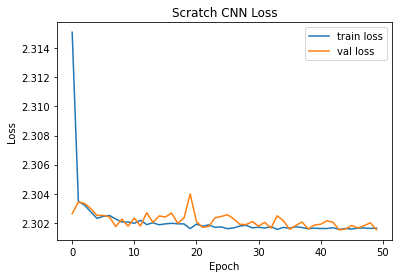

In [988]:
# ハイパーパラメータの設定 w(F,C,Lf) b(F)
W1 = np.array((4,1,6)); B1 = 4
W2 = np.array((8,4,6)); B2 = 8
W3 = np.array((16,8,3)); B3 = 16
W4 = np.array((752,188)); B4 = 188
W5 = np.array((188,10)); B5 = 10

# 5層のネットワーク
layer_1 = Layer(Conv1d(pad='SAME', stride=4), ReLu(), HeInitializer(), AdaGrad(), 784, W1, B1)  # 1,784 to 4,196
layer_2 = Layer(Conv1d(pad='SAME', stride=4), ReLu(), HeInitializer(), AdaGrad(), 4*196, W2, B2)  # 4,196 to 8,49
layer_3 = Layer(Conv1d(pad='VALID', stride=1), ReLu(), HeInitializer(), AdaGrad(), 8*49, W3, B3)  # 8,49 to 16,47
layer_4 = Layer(None, Flatten())  # 16,47 to 752,
layer_5 = Layer(Linear(), Sigmoid(), XavierInitializer(), AdaGrad(), 752, W4, B4)  # 752, to 188,
output = Layer(Linear(), Softmax(), XavierInitializer(), AdaGrad(), 188, W5, B5)  # 188, to 10,

params = {'epoch': 10, 
          'lr': 0.01,
          'batch_size': 200,
          }

cnn = Scratch1dCNNClassifier(layers=[layer_1, layer_2, layer_3, layer_4, layer_5, output],
                             verbose=True, **params)

cnn.fit(X_train, y_train, X_val, y_val)

pred = cnn.predict(X_test)

print("\nTest Accuracy: {}".format(accuracy_score(y_test, pred)))

plot_loss(cnn)

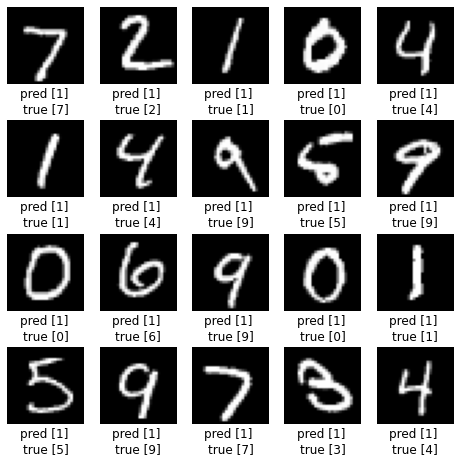

In [989]:
# 推定結果を確認
plt.figure(figsize=(8,8))
for i in range(20):
    pred = cnn.predict(X_test[i][None,...])
    true = y_test[i]
    plt.subplot(4, 5, i+1)
    plt.imshow(X_test[i].reshape(28,28), 'gray')
    plt.title('pred {} \ntrue [{}]'.format(pred, true), y=-0.45)
    plt.axis('off')